#Research

In [1]:
import numpy as np
import pandas as pd

In [2]:
path = "/BST_DataSet.xlsx"

In [4]:
df = pd.read_excel(path)

In [7]:
df.head()

,Unnamed: 0,Прирост вкладов физических лиц в рублях (млн руб),Доходность ОФЗ по сроку до 1 года,Ключевая ставка,Ставка по вкладам в долларах до 1 года,Ставка по вкладам в рублях до 1 года,"Нефть марки Юралс, долл./барр","Индекс потребительских цен, ед.","М0, руб","М2, руб","Курс доллара к рублю, руб","Номинальная средняя з/п, руб"
0,2011-01-01,-79049.0,5.244667,7.75,2.9,4.5,96.29,106.17151,5532900.0,19307.7,30.08,20669
1,2011-02-01,180475.0,5.144211,8.00,3.1,4.4,103.96,106.99964,5613700.0,19536.7,29.29,20680
2,2011-03-01,106845.0,5.021364,8.00,3.1,4.2,114.44,107.66304,5647000.0,19788.7,28.43,22673
3,2011-04-01,224890.0,4.558571,8.00,2.6,4.1,123.15,108.12599,5863400.0,20020.8,28.10,22519
4,2011-05-01,45856.0,4.795000,8.25,2.6,4.1,114.46,108.64500,5893400.0,20160.9,27.87,22779


In [8]:
#Переименнуем столбец для удобства
df.rename(columns={"Unnamed: 0":"Date"}, inplace=True)
df["Year"]=df.Date.dt.year

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 13 columns):
 #   Column                                             Non-Null Count  Dtype         
---  ------                                             --------------  -----         
 0   Date                                               84 non-null     datetime64[ns]
 1   Прирост вкладов физических лиц в рублях (млн руб)  72 non-null     float64       
 2   Доходность ОФЗ по сроку до 1 года                  84 non-null     float64       
 3   Ключевая ставка                                    84 non-null     float64       
 4   Ставка по вкладам в долларах до 1 года             84 non-null     float64       
 5   Ставка по вкладам в рублях до 1 года               84 non-null     float64       
 6   Нефть марки Юралс, долл./барр                      84 non-null     float64       
 7   Индекс потребительских цен, ед.                    84 non-null     float64       
 8   М0, руб               

Данные содержать пропущенные значения. В данном случае они служат для прогноза

In [10]:
list(df.columns)

['Date',
 'Прирост вкладов физических лиц в рублях (млн руб)',
 'Доходность ОФЗ по сроку до 1 года',
 'Ключевая ставка',
 'Ставка по вкладам в долларах до 1 года',
 'Ставка по вкладам в рублях до\xa01\xa0года',
 'Нефть марки Юралс, долл./барр',
 'Индекс потребительских цен, ед.',
 'М0, руб',
 'М2, руб',
 'Курс доллара к рублю, руб',
 'Номинальная средняя з/п, руб',
 'Year']

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


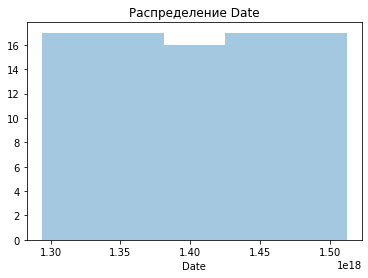

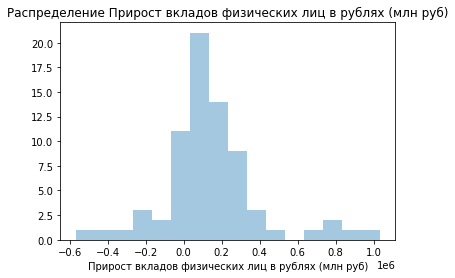

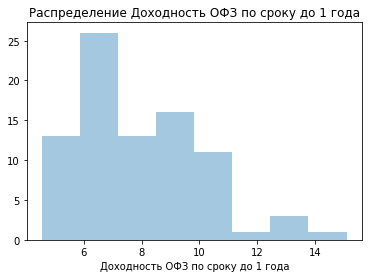

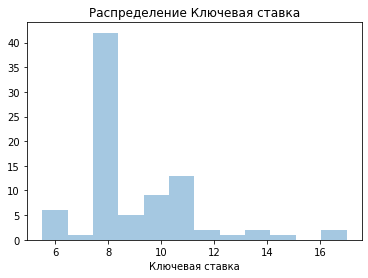

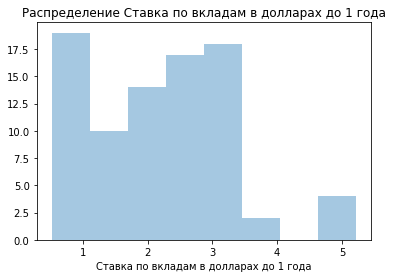

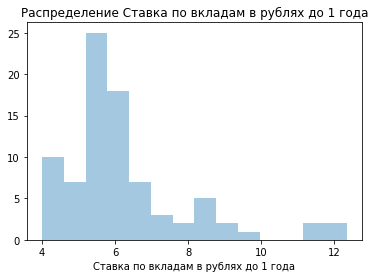

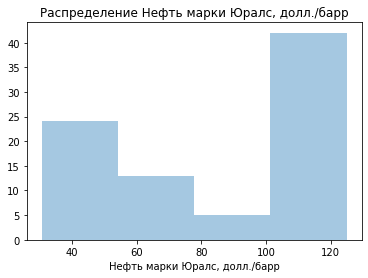

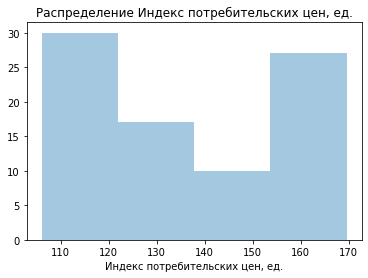

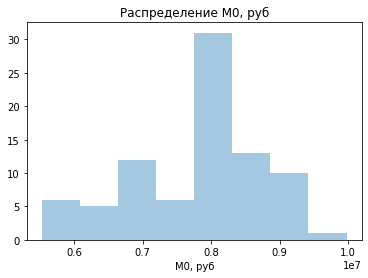

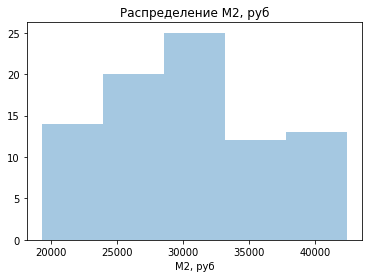

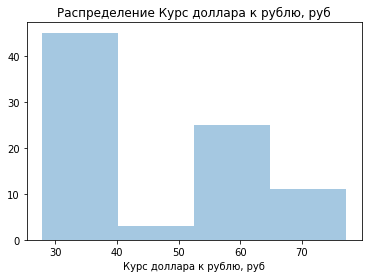

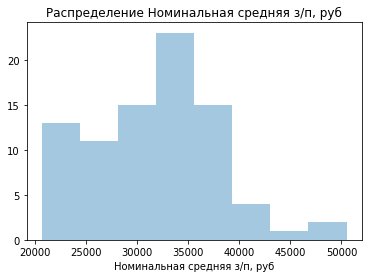

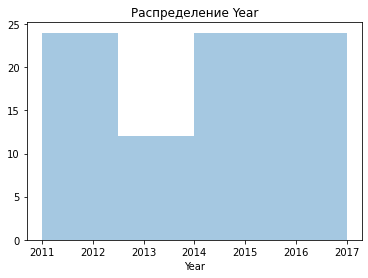

In [12]:
#Посмотрим на распределение признаков
for col in list(df.columns):
    plt.figure()
    plt.title(f"Распределение {col}")
    sns.distplot(df[col], kde=False)

In [13]:
# признаки, которые имеют ярко выраженное смещение вправо, мы логарифмируем, для того,
# чтобы распределение было больше похоже на нормальное, остальные оставим как есть
skewed_features = [
 'Доходность ОФЗ по сроку до 1 года',
 'Ставка по вкладам в долларах до 1 года',
 'Ключевая ставка',
  ]
df[skewed_features] = np.log(df[skewed_features])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


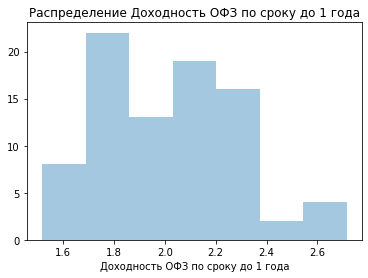

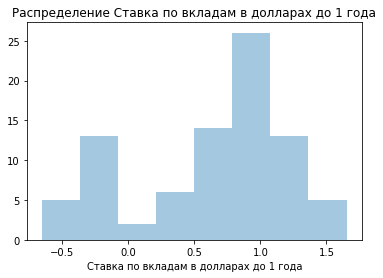

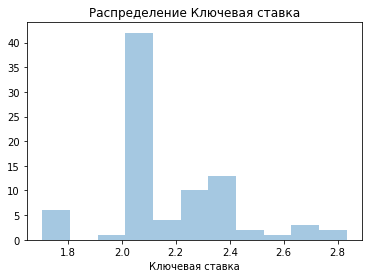

In [14]:
# распределение логарифмированных признаков, стало более похоже на нормальное
for col in skewed_features:
    plt.figure()
    plt.title(f"Распределение {col}")
    sns.distplot(df[col], kde=False)

In [15]:
#Числовые признаки
num_cols = ['Доходность ОФЗ по сроку до 1 года',
 'Ключевая ставка',
 'Ставка по вкладам в долларах до 1 года',
 'Ставка по вкладам в рублях до\xa01\xa0года',
 'Нефть марки Юралс, долл./барр',
 'Индекс потребительских цен, ед.',
 'М0, руб',
 'М2, руб',
 'Курс доллара к рублю, руб',
 'Номинальная средняя з/п, руб',
]

#Feature engineering


In [16]:
#Добавим новые фичи
from sklearn.preprocessing import PolynomialFeatures, StandardScaler,OneHotEncoder

# добавим новые признаки, которые являются комбинациями числовых признаков
poly = PolynomialFeatures(2, include_bias=False)
poly_data = poly.fit_transform(df[num_cols])[:, len(num_cols):]
poly_cols = poly.get_feature_names()[len(num_cols):]
poly_df = pd.DataFrame(poly_data, columns=poly_cols)
data = pd.concat([df, poly_df], axis=1)

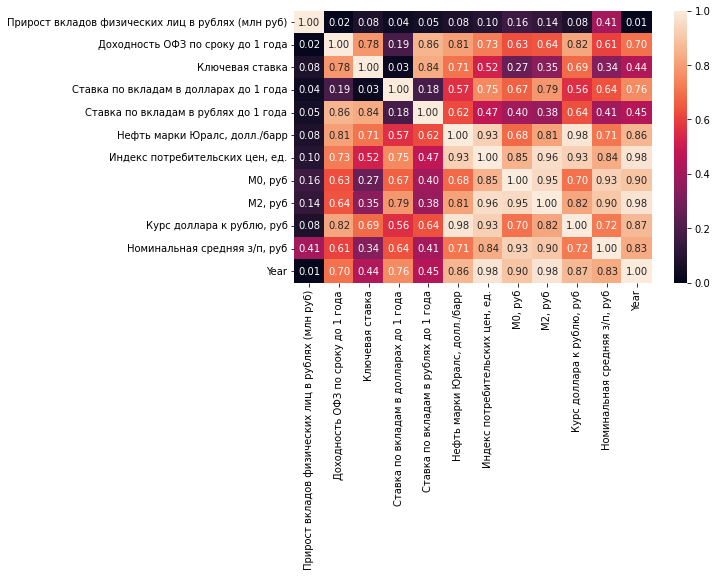

In [17]:
# посмотрим на корреляцию признаков между собой
plt.figure(figsize=(8, 5))
sns.heatmap(df[list(df.columns)].corr().abs(), vmin=0, vmax=1, annot=True, fmt=".2f")

Признаки сильно коррелированы между собой, что нужно будет учесть при формировании модели. Наибольшую линеную взаимосвязь с целевой переменной имеет признак "Номинальная средняя з/п, руб"

In [18]:
#Разделим dataset, с учетом данных для прогноза
data_fill = data[data['Date']<"01.01.2017"]
data_for_pred = data[data['Date']>="01.01.2017"]

In [19]:
data_fill.head()

,Date,Прирост вкладов физических лиц в рублях (млн руб),Доходность ОФЗ по сроку до 1 года,Ключевая ставка,Ставка по вкладам в долларах до 1 года,Ставка по вкладам в рублях до 1 года,"Нефть марки Юралс, долл./барр","Индекс потребительских цен, ед.","М0, руб","М2, руб","Курс доллара к рублю, руб","Номинальная средняя з/п, руб",Year,x0^2,x0 x1,x0 x2,x0 x3,x0 x4,x0 x5,x0 x6,x0 x7,x0 x8,x0 x9,x1^2,x1 x2,x1 x3,x1 x4,x1 x5,x1 x6,x1 x7,x1 x8,x1 x9,x2^2,x2 x3,x2 x4,x2 x5,x2 x6,x2 x7,x2 x8,x2 x9,x3^2,x3 x4,x3 x5,x3 x6,x3 x7,x3 x8,x3 x9,x4^2,x4 x5,x4 x6,x4 x7,x4 x8,x4 x9,x5^2,x5 x6,x5 x7,x5 x8,x5 x9,x6^2,x6 x7,x6 x8,x6 x9,x7^2,x7 x8,x7 x9,x8^2,x8 x9,x9^2
0,2011-01-01,-79049.0,1.657212,2.047693,1.064711,4.5,96.29,106.17151,5532900.0,19307.7,30.08,20669,2011,2.746351,3.393461,1.764451,7.457453,159.572913,175.948667,9.169187e+06,31996.946094,49.848928,34252.908364,4.193046,2.180201,9.214618,197.172344,217.406641,1.132968e+07,39536.239112,61.594601,42323.763380,1.133609,4.791198,102.520997,113.041947,5.890938e+06,20557.115497,32.026499,22006.506223,20.25,433.305,477.771795,24898050.0,86884.65,135.360,93010.5,9271.7641,10223.254698,532762941.0,1859138.433,2896.4032,1990218.01,11272.389536,5.874363e+08,2.049928e+06,3193.639021,2.194459e+06,3.061298e+13,1.068276e+11,166429632.0,1.143595e+11,3.727873e+08,580775.616,399070851.3,904.8064,621723.52,427207561.0
1,2011-02-01,180475.0,1.637872,2.079442,1.131402,4.4,103.96,106.99964,5613700.0,19536.7,29.29,20680,2011,2.682624,3.405859,1.853092,7.206636,170.273164,175.251705,9.194522e+06,31998.612196,47.973268,33871.191154,4.324077,2.352685,9.149543,216.178743,222.499496,1.167336e+07,40625.425567,60.906843,43002.851082,1.280071,4.978169,117.620564,121.059619,6.351352e+06,22103.863632,33.138768,23397.395666,19.36,457.424,470.798416,24700280.0,85961.48,128.876,90992.0,10807.6816,11123.682574,583600252.0,2031035.332,3044.9884,2149892.80,11448.922960,6.006639e+08,2.090420e+06,3134.019456,2.212753e+06,3.151363e+13,1.096732e+11,164425273.0,1.160913e+11,3.816826e+08,572229.943,404018956.0,857.9041,605717.20,427662400.0
2,2011-03-01,106845.0,1.613702,2.079442,1.131402,4.2,114.44,107.66304,5647000.0,19788.7,28.43,22673,2011,2.604033,3.355598,1.825745,6.777546,184.672004,173.736013,9.112573e+06,31933.055616,45.877535,36587.454960,4.324077,2.352685,8.733654,237.971290,223.878998,1.174261e+07,41149.444836,59.118523,47147.178075,1.280071,4.751889,129.477658,121.810191,6.389028e+06,22388.976964,32.165762,25652.280074,17.64,480.648,452.184768,23717400.0,83112.54,119.406,95226.6,13096.5136,12320.958298,646242680.0,2264618.828,3253.5292,2594698.12,11591.330182,6.079732e+08,2.130512e+06,3060.860227,2.441044e+06,3.188861e+13,1.117468e+11,160544210.0,1.280344e+11,3.915926e+08,562592.741,448669195.1,808.2649,644593.39,514064929.0
3,2011-04-01,224890.0,1.517009,2.079442,0.955511,4.1,123.15,108.12599,5863400.0,20020.8,28.10,22519,2011,2.301317,3.154532,1.449520,6.219738,186.819694,164.028131,8.894832e+06,30371.739618,42.627961,34161.532229,4.324077,1.986930,8.525710,256.083226,224.841675,1.219260e+07,41632.083218,58.432307,46826.944077,0.913002,3.917597,117.671234,103.315621,5.602546e+06,19130.103539,26.849872,21517.162231,16.81,504.915,443.316559,24039940.0,82085.28,115.210,92327.9,15165.9225,13315.715669,722077710.0,2465561.520,3460.5150,2773214.85,11691.229713,6.339859e+08,2.164769e+06,3038.340319,2.434889e+06,3.437946e+13,1.173900e+11,164761540.0,1.320379e+11,4.008324e+08,562584.480,450848395.2,789.6100,632783.90,507105361.0
4,2011-05-01,45856.0,1.567574,2.110213,0.955511,4.1,114.46,108.64500,5893400.0,20160.9,27.87,22779,2011,2.457287,3.307915,1.497835,6.427052,179.424487,170.309046,9.238339e+06,31603.696776,43.688279,35707.761502,4.453000,2.016333,8.651874,241.535003,229.264113,1.243633e+07,42543.797311,58.811642,48068.546491,0.913002,3.917597,109.367840,103.811541,5.631211e+06,19263.970692,26.630104,21765.595206,16.81,469.286,445.444500,24162940.0,82659.69,114.267,93393.9,13101.0916,12435.506700,674558564.0,2307616.614

#Feature Selection

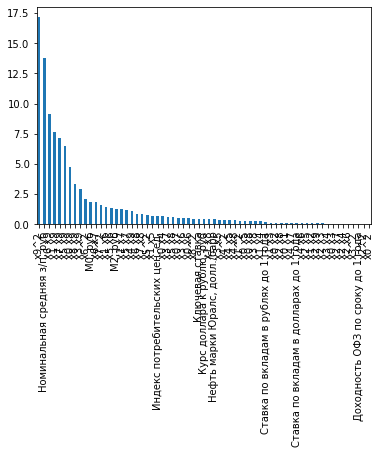

In [20]:
#С помощью F-test оценим значимость признаков
from sklearn.feature_selection import f_regression
imp_num = pd.Series(f_regression(data_fill[num_cols+poly_cols], data_fill['Прирост вкладов физических лиц в рублях (млн руб)'])[0], index=num_cols+poly_cols)
imp_num.sort_values(inplace=True, ascending=False)
imp_num.plot(kind="bar") 

In [21]:
#Для модели отберем только те признаки, значение F-статистики больше 2,5
selected_features = imp_num[imp_num>2.5].index

In [22]:
x = data_fill[selected_features]
y = data_fill['Прирост вкладов физических лиц в рублях (млн руб)']
x_for_pred = data_for_pred[selected_features]

In [80]:
#Отнормируем данные
from sklearn.preprocessing import StandardScaler
x[selected_features]= StandardScaler().fit_transform(x[selected_features])
x_for_pred[selected_features] = StandardScaler().fit_transform(x_for_pred[selected_features])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

#Model selection and predict

In [102]:
#Модель должна быть интерпритируема воспользуемся линейной моделью 
#Т.к. признаки сильно коррелируют между собой, нужно штрафовать веса, если они слишком большие. 
#Также будем использовать кросс-валидацию, т.к. данных очень мало

from sklearn.linear_model import RidgeCV, LinearRegression

model1 = RidgeCV()
model2 = LinearRegression()
model1.fit(x,y)
model2.fit(x,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [100]:
model.coef_

array([ 361445.25274686,  273404.60573639, -228916.53891704,
        122763.79216822, -182736.58998785,  -44250.38157048,
       -186871.44836673,   16809.22283713,  -42914.52570717])

In [104]:
r_sq1 = model1.score(x, y)
r_sq2 = model2.score(x, y)
print('With L2 and CV coefficient of determination:', r_sq1)
print('coefficient of determination:', r_sq2)

With L2 and CV coefficient of determination: 0.5039915367903063
coefficient of determination: 0.56564330658905


In [109]:
#Т.к. второая модель имеет более высокий показатель метрики качества, выбираем ее
model2.predict(x_for_pred)

array([114633.09448259,  80434.45093599, 258145.97733683, 174694.09090843,
       270696.38210456, 334301.52457821,  -8998.42816472, -48156.44088668,
        16567.28019584,   4424.03455908,  82995.81673032, 479948.21721954])